# Austin Geography

This kernel will just present Austin census data and police precincts together. We also hope to find a good projection.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# tools

# ESRI:102003
# USA_Contiguous_Albers_Equal_Area_Conic
equal_area_proj = ('+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs ')

def project(geom, p1, p2=equal_area_proj):
    """Convert geom from p1 to p2
    
    Parameters
    ----------
    geom: shapely geometry object
    p1: str or dict
        Parameters for the original projection
    p2: str or dict
        Parameters for the desired projection
        
    Returns
    -------
    shapely geometry object
        An object equivalent to geom, but
        projected into p2 instead
    """
    import pyproj
    from functools import partial    
    from shapely.ops import transform
    
    p1 = pyproj.Proj(p1, preserve_units=True)
    p2 = pyproj.Proj(p2, preserve_units=True)
    project = partial(pyproj.transform, p1, p2)
    transformed = transform(project, geom)
    return transformed

# Police precincts

In [3]:
# there's no projection
!ls ../../data/raw/cpe-data/Dept_37-00027/37-00027_Shapefiles/

APD_DIST.dbf  APD_DIST.sbn  APD_DIST.sbx  APD_DIST.shp	APD_DIST.shx


In [4]:
loc = '../../data/raw/cpe-data/Dept_37-00027/37-00027_Shapefiles/'
df = gpd.read_file(loc)

In [5]:
df.head()

,NAME,SORTORDER,BATID,JURIID,COLOR,CODE,EXTERNALKE,BATTALIONC,DISTRICT,SECTOR,INPUT_DATE,MODIFIED_D,INPUT_BY,MODIFIED_B,BUREAU,PATROL_ARE,AREACOMMAN,SHAPE_AREA,SHAPE_LEN,geometry
0,CHARLIE 4,1.0,400.0,11.0,16744576.0,1282,1282,CHAR,CHARLIE 4,CHARLIE,2014-12-22,None,bmartinlimuel,None,CENTRAL,CENTRALEAST,512-974-5900,6.657440e+08,387953.791071,"POLYGON ((3160030.801874995 10110945.26125, 31..."
1,GEORGE 1,1.0,194.0,15.0,16744576.0,1298,1298,G1,GEORGE 1,GEORGE,2014-12-22,None,bmartinlimuel,None,NORTH,DTAC,512-974-5203,2.790690e+07,23590.887752,"POLYGON ((3117569.753749996 10072205.20874999,..."
2,GEORGE 2,1.0,194.0,15.0,16776960.0,1297,1297,G1,GEORGE 2,GEORGE,2014-12-22,None,bmartinlimuel,None,NORTH,DTAC,512-974-5203,9.667245e+06,19773.819675,"POLYGON ((3117394.076875001 10072195.676875, 3..."
3,IDA 1,1.0,215.0,60.0,16744576.0,1307,1307,I1,IDA 1,IDA,2014-12-22,None,bmartinlimuel,None,CENTRAL,NORTHCENTRAL,512-974-5203,1.054603e+08,48972.544807,"POLYGON ((3138058.366874993 10093095.421875, 3..."
4,IDA 2,1.0,215.0,60.0,16711680.0,1304,1304,I1,IDA 2,IDA,2014-12-22,None,bmartinlimuel,None,CENTRAL,NORTHCENTRAL,512-974-5203,6.245594e+07,38742.443899,"POLYGON ((3132516.318124995 10096385.60124999,..."


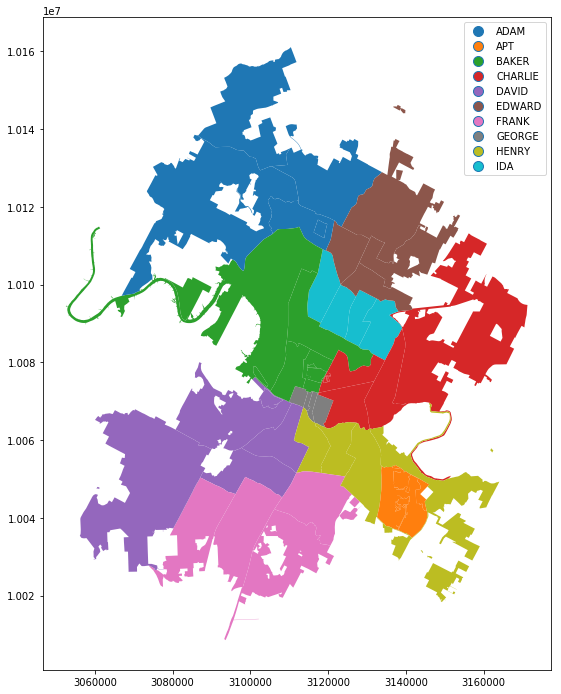

In [6]:
df.plot(column='SECTOR', legend=True, figsize=(16, 12))

In [7]:
police = df.copy()  # export

# Census tracts

This data will be downloaded from [TIGER][1]. Later we will want to align it with the precincts data.

[census data is mostly from 2015][2]

[1]: https://www.census.gov/geo/maps-data/data/tiger.html
[2]: https://www.kaggle.com/center-for-policing-equity/data-science-for-good/discussion/67959

In [8]:
loc = '../../data/raw/census_tx/'
df = gpd.read_file(loc)

In [9]:
df.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,48,201,542301,48201542301,5423.01,Census Tract 5423.01,G5020,S,5956745,15456,+29.8204990,-095.7316493,"POLYGON ((-95.75223799999999 29.831686, -95.75..."
1,48,157,673800,48157673800,6738,Census Tract 6738,G5020,S,14100074,1008190,+29.5874575,-095.7125243,"POLYGON ((-95.758386 29.583531, -95.757993 29...."
2,48,157,674000,48157674000,6740,Census Tract 6740,G5020,S,4826110,65291,+29.5869509,-095.6224534,"POLYGON ((-95.63467299999999 29.589525, -95.63..."
3,48,157,674100,48157674100,6741,Census Tract 6741,G5020,S,4170610,0,+29.5791692,-095.5995891,"POLYGON ((-95.614667 29.578282, -95.6133859999..."
4,48,201,552601,48201552601,5526.01,Census Tract 5526.01,G5020,S,2911911,4263,+29.9629845,-095.5679180,"POLYGON ((-95.585241 29.966226, -95.5852209999..."


In [10]:
df.crs

{'init': 'epsg:4269'}

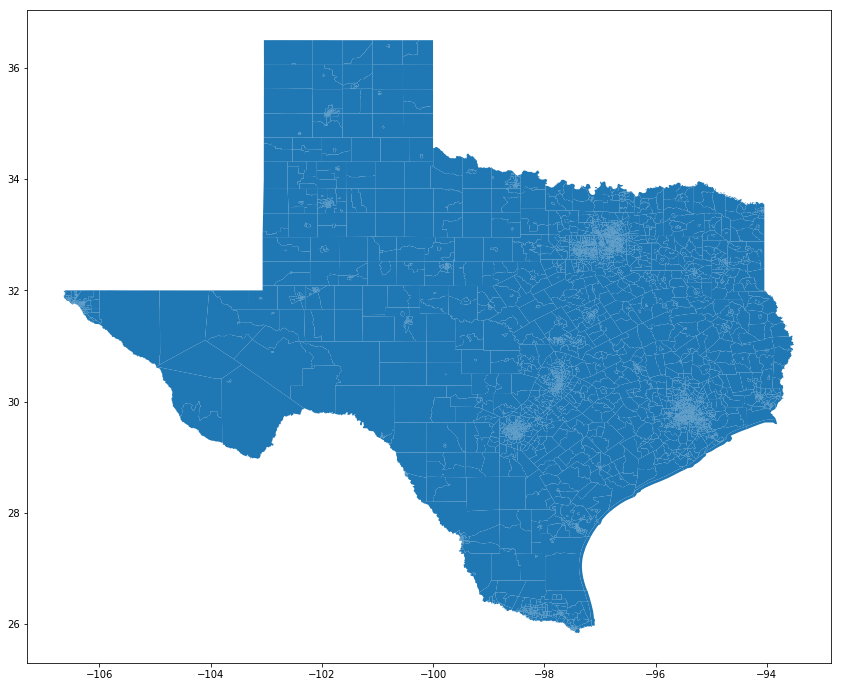

In [11]:
df.plot(figsize=(16, 12))

In [12]:
census = df.copy()  # export

Very beautiful, now we need to...

# Normalize the projections

Both shapefiles are in different projections (or similar). Worse still, the projection for the police precints is unknown. Here I will try educated guesses and then compare the shapes to see if they match.

In [13]:
# ESRI:102739
# NAD 1983 StatePlane Texas Central FIPS 4203 Feet
proj1 = '+proj=lcc +lat_1=30.11666666666667 +lat_2=31.88333333333333 +lat_0=29.66666666666667 +lon_0=-100.3333333333333 +x_0=700000 +y_0=3000000 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 no_defs'

pol1 = police.copy()
pol1['geometry'] = police['geometry'].apply(lambda x: project(x, proj1))

cen1 = census.copy()
cen1['geometry'] = cen1['geometry'].apply(lambda x: project(x, cen1.crs))

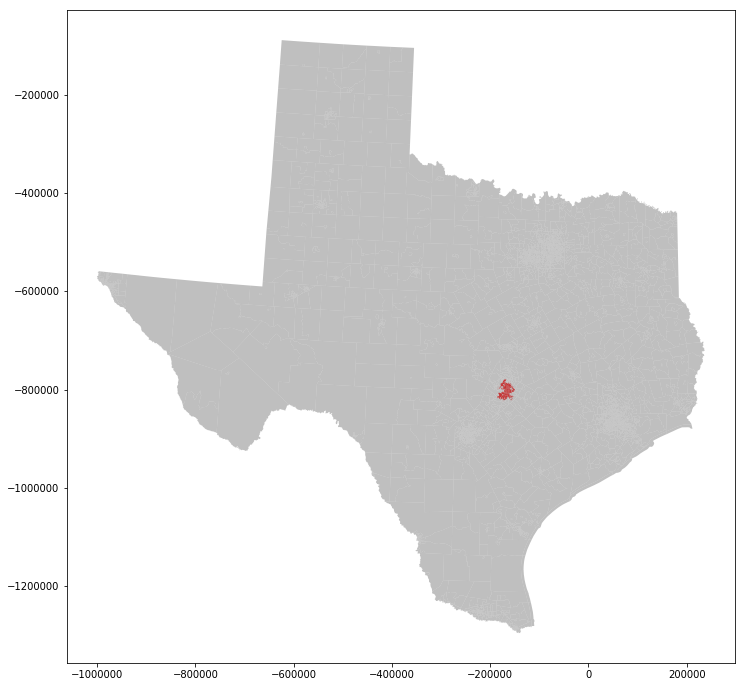

In [14]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')

pol1.plot(ax=ax, color='red')
cen1.plot(ax=ax, color='grey', alpha=0.5)

(-825828.603433, -777509.027248)

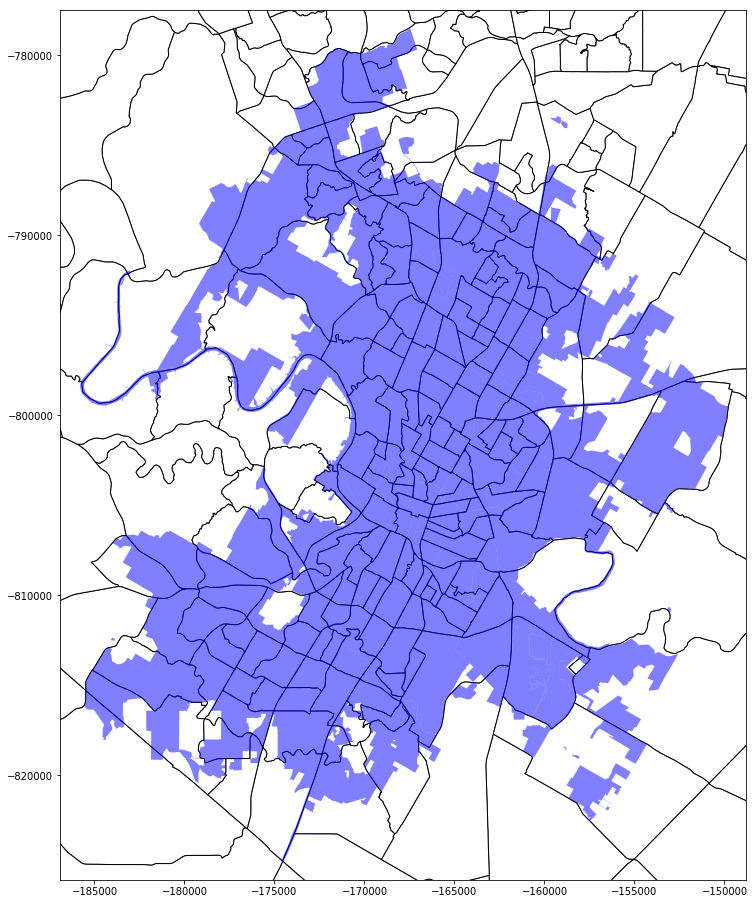

In [15]:
fig, ax = plt.subplots(figsize=(20, 16))

ax.set_aspect('equal')

cen1.plot(ax=ax, facecolor='white', edgecolor='black')
pol1.plot(ax=ax, color='blue', alpha=0.5)

ax.set_xlim(
    -185896.623374 - 1000,
    -149797.532218 + 1000,
)

ax.set_ylim(
    -824828.603433 - 1000,
    -778509.027248 + 1000,
)

That river contour is just perfect, so, I assume this is the right projection :D